In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model

import keras.applications.resnet50 as resnet
from keras.layers import UpSampling2D, Conv2D

Using TensorFlow backend.


In [2]:
INPUT_IMG_FILE = "dictomy.jpg"

In [3]:
NETWORK_INPUT_SIZE = 224
MODEL_CLASS = resnet.ResNet50
PREPROCESS_FN = resnet.preprocess_input
LAST_CONV_LAYER = "activation_49"
PRED_LAYER = "fc1000"

In [4]:
# number of imagenet classes
N_CLASSES = 1000

In [5]:
def load_img(fname, input_size, preprocess_fn):
    original_img = cv2.imread(fname)[:, :, ::-1]
    original_size = (original_img.shape[1], original_img.shape[0])
    img = cv2.resize(original_img, (input_size, input_size))
    imgs = np.expand_dims(preprocess_fn(img), axis=0)
    return imgs, original_img, original_size

In [6]:
def get_cam_model(model_class, input_size=224, last_conv_layer="activation_49", pred_layer="fc1000"):
    model = model_class(input_shape=(input_size, input_size, 3))

    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, N_CLASSES), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    x = UpSampling2D(size=(32, 32), interpolation="bilinear")(last_conv_output)
    x = Conv2D(filters=N_CLASSES, kernel_size=(1, 1), name="predictions_2")(x)

    cam_model = Model(inputs=model.input,
                      outputs=[model.output, x])
    cam_model.get_layer("predictions_2").set_weights(final_params)
    return cam_model


In [7]:
def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map

### first load image

In [9]:
imgs, original_img, original_size = load_img(INPUT_IMG_FILE, 
                                             input_size=NETWORK_INPUT_SIZE, preprocess_fn=resnet.preprocess_input)

### Prediction

In [10]:
model = get_cam_model(resnet.ResNet50,
                      NETWORK_INPUT_SIZE,
                      LAST_CONV_LAYER,
                      PRED_LAYER)
preds, cams = model.predict(imgs)

Instructions for updating:
Colocations handled automatically by placer.
102858752/102853048 [==============================] - 62s 1us/step


### post processing

In [11]:
class_activation_map = postprocess(preds, cams)

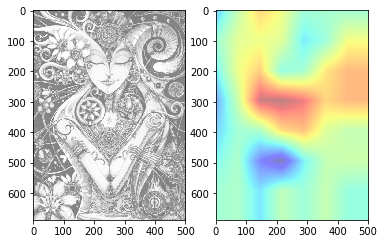

In [15]:
plt.subplot(121)
plt.imshow(original_img, alpha=0.5)

plt.subplot(122)
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5)
plt.show()

### picture of dog

Instructions for updating:
Colocations handled automatically by placer.


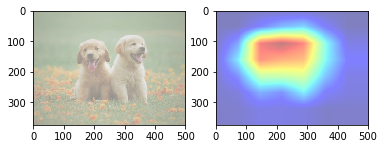

In [8]:
imgs, original_img, original_size = load_img('dog.jpeg', 
                                             input_size=NETWORK_INPUT_SIZE, preprocess_fn=resnet.preprocess_input)

model = get_cam_model(resnet.ResNet50,
                      NETWORK_INPUT_SIZE,
                      LAST_CONV_LAYER,
                      PRED_LAYER)
preds, cams = model.predict(imgs)

class_activation_map = postprocess(preds, cams)

plt.subplot(121)
plt.imshow(original_img, alpha=0.5)

plt.subplot(122)
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5)
plt.show()

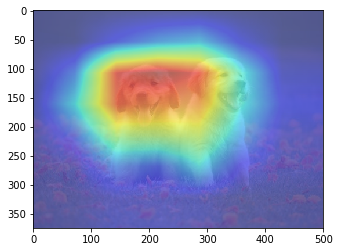

In [9]:
plt.imshow(original_img, alpha=0.5)
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5)

Instructions for updating:
Colocations handled automatically by placer.


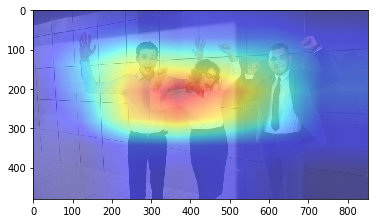

In [9]:
imgs, original_img, original_size = load_img('human.jpg', 
                                             input_size=NETWORK_INPUT_SIZE, preprocess_fn=resnet.preprocess_input)

model = get_cam_model(resnet.ResNet50,
                      NETWORK_INPUT_SIZE,
                      LAST_CONV_LAYER,
                      PRED_LAYER)
preds, cams = model.predict(imgs)

class_activation_map = postprocess(preds, cams)

plt.imshow(original_img, alpha=0.5)
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5)

In [5]:
MODEL_CLASS(input_shape=(224, 224, 3)).summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________